### Transformer
> * 基于编码器-解码器架构来处理序列对
> * 跟使用注意力的seq2seq不同，Transformer是纯基于注意力
> ![](../images/Transformer.png)

### 多头注意力机制
> * 对同一key，value，query，只希望抽取不同的信息
>> * 例如短距离关系和长距离关系
> * 多头注意力使用h个独立的注意力池化
>> * 合并各个头（head）输出得到最终输出
>  ![](../images/MultiHead-Attention.png)

### 多头注意力机制的可学习参数
> * $query\quad q\in\mathbb{R}^{d_q},key\quad k\in\mathbb{R}^{d_k},value\quad v\in\mathbb{R}^{d_v}$
> * 头$i$的可学习参数$W_i^{(q)}\in\mathbb{R}^{p_q\times d_q},W_i^{(k)}\in\mathbb{R}^{p_k\times d_k},W_i^{(v)}\in\mathbb{R}^{p_v\times d_v}$
> * 头i的输出$h_i=f(W_i^{(q)}q,W_i^{(k)}k,W_i^{(v)}v)\in\mathbb{R}^{p_v}$
> * 输出的可学习参数$W_o\in\mathbb{R}^{p_o\times hp_v}$
> * 多头注意力的输出:$$W_o\begin{bmatrix}
h_1\\
.\\
.\\
.\\
h_h
\end{bmatrix}\in\mathbb{R}^{p_o}$$

### 有掩码的多头注意力
> * 解码器对序列中一个元素输出时，不应该考虑该元素之后的元素
> * 可以通过掩码实现
>> * 也就是计算$x_i$输出时，假装当前序列长度为$i$

### 基于位置的前馈网络
> * 将输入形状由$(b,n,d)$变换成$(bn,d)$
> * 作用两个全连接层
> * 输出形状由$(bn,d)$变化为$(b,n,d)$
> * 等价于两层核窗口为1的一维卷积层

### 层归一化
> * 批量归一化度每个特征/通道里元素进行归一化
>> * 不适合序列长度会变的NLP应用
> * 层归一化对每个样本里的元素进行归一化
> ![](../images/Add&Norm.png)

### 信息传递
> * 编码器中的输出$y_1,..,y_n$
> * 将其作为解码中第$i$个Transformer块中多头注意力的key和value
>> * 它的query来自目标序列
> * 意味着编码器和解码器中块的个数和输出维度都是一样的

### 预测
> * 预测第$t+1$个输出时
> * 解码器中输入前$t$个预测值
>> * 在自注意力中，前$t$个预测值作为key和value，第$t$个预测值还作为query
> ![](../images/Transformer-predicted.png)

### 总结
> * Transformer是一个纯使用注意力的编码-解码器
> * 编码器和解码器都有n个transformer块
> * 每个块里使用多头（自）注意力，基于位置的前馈网络和层归一化

In [1]:
import math
import torch
from torch import nn

import d2l.limutorch
from d2l import limutorch as d2l

In [3]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状：（batch_size,查询或者“键值对”个数,num_hiddens）
    # 输出X的形状：（batch_size,查询或者“键值对”个数,num_heads, num_hiddens/num_heads）
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状调整为：（batch_size,num_heads,查询或者“键值对”个数,num_hiddens/num_heads）
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状为（batch_size*num_heads,查询或者”键值对“个数,num_hiddens/num_heads）
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [11]:
class MultiHeadAttention(nn.Module):
    """多头注意力机制"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads,
                 dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries,keys,values的形状为：（batch_size,查询或者“键值对”的个数,num_hiddens）
        # valid_lens的形状（batch_size,）或者（batch_size,查询个数）
        # 经过变换后，queries,keys,values形状为：
        # （batch_size*num_heads,查询或者“键值对”个数,num_hiddens/num_heads）
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次
            # 然后如此复制第二项，然后诸如此类
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)

        # output形状为：（batch_size*num_heads,查询个数,num_hiddens/num_heads）
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状为：（batch_size,查询个数,num_hiddens）
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [12]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [13]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

In [14]:
import pandas as pd

In [16]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [17]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.5976, -0.3540, -0.5205,  0.1748,  0.0605,  0.1139,  0.5144,  0.5526],
        [-0.5976, -0.3540, -0.5205,  0.1748,  0.0605,  0.1139,  0.5144,  0.5526],
        [-0.5976, -0.3540, -0.5205,  0.1748,  0.0605,  0.1139,  0.5144,  0.5526]],
       grad_fn=<SelectBackward0>)

In [19]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:',ln(X), '\nbatch norm:', bn(X))
X

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


tensor([[1., 2.],
        [2., 3.]])

In [21]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [23]:
"""残差连接要求两个输入形状相同，以便假发操作后输出张量的形状相同"""
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [25]:
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads,
                                            dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [26]:
"""Transformer编码器中的任何层都不会改变其输入的形状"""
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [28]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False,
                 **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，因此嵌入值乘以嵌入维度的平方根进行缩放，然后再与位置编码相加
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X


In [29]:
"""Transformer编码器输出的形状是（批量大小， 时间步数目，num_hiddens）"""
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [34]:
class DecoderBlock(nn.Module):
    """解码器中第i块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size,
                                             num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = MultiHeadAttention(key_size, query_size, value_size,
                                             num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，因此state[2][self.i]初始化为None，
        # 预测阶段，输出序列是通过词元一个接着一个解码的，因此state[2][self.i]包含知道当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dev_valid_lens的开头：（batch_size, num_steps），其中每一行是[1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器-解码器注意力
        # enc_outputs的开头：（batch_size,num_steps,num_hiddens）
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [35]:
"""为了便于在”编码器-解码器“注意力中进行缩放点积计算和残差连接中进行加法计算，编码器和解码器的特征维度都是num_hiddens"""
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [39]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                              norm_shape, ffn_num_input, ffn_num_hiddens,
                                              num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器-解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.034, 4039.1 tokens/sec on cuda:0


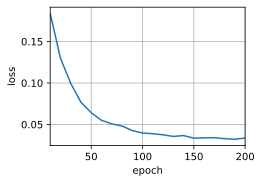

In [40]:
"""训练"""
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens,
                            norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                            num_layers, dropout)

decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                             num_layers, dropout)

net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [42]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab,
                                                                tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, belu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !, belu 1.000
i lost . => je vous en perdu ., belu 0.447
he's calm . => il est calme ., belu 1.000
i'm home . => je suis chez moi ., belu 1.000


In [43]:
"""编码器自注意力权重的形状为（编码器层数， 注意力头数， num_steps或者查询的数目，num_steps或者“键值对”数目）"""
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
                                                                             -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

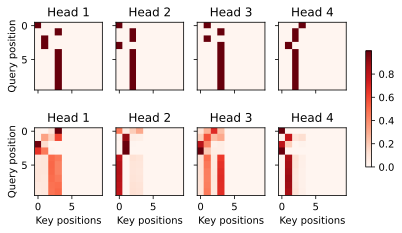

In [44]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query position', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5)
)

In [45]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step
                            for blk in attn
                            for head in blk]
dec_attention_weight_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values
)

dec_attention_weights = dec_attention_weight_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

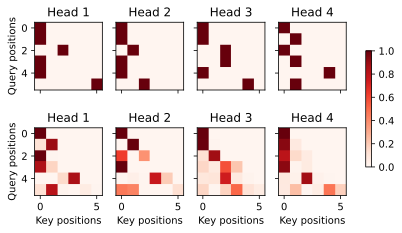

In [46]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5)
)

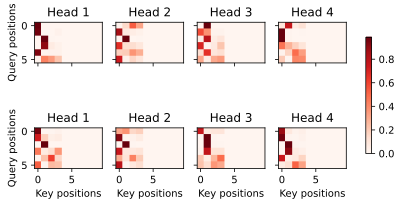

In [47]:
d2l.show_heatmaps(
    dec_inter_attention_weights,xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5)
)